# Stock Volatility with Ornstein-Uhlenbeck
### By François Goujon 

$dX_t = - \kappa X_t dt + \sigma dW_t$ <br>
$dX_t = \kappa(\theta - X_t)dt + \sigma dW_t$ <br> 

Continuous-time stochastic process:

$X_t = X_0 e^{-\kappa t} + \theta (1 - e^{-\kappa t} + \sigma \int_{0}^{t} t_0e^{-\kappa (t-s)}dW_s$

Euler-Maryuama discretisation:
$X_{t+1} = X_{t} +  \kappa (\theta - X_t)\Delta t + \sigma \sqrt{t} Z$ and $ Z \sim N(0,1)$

In [233]:
# Imports
import math
import numpy as np
import pandas as pd
import time
from datetime import date
import scipy as sc
import matplotlib.pyplot as plt
import yfinance as yf
import seaborn as sns

### Functions

In [248]:
def get_data(ticker):
    """
    Retrieve data from yfinance
    Input: ticker (String)
    Output: price dataframe (pd.DataFrame)
    """
    end = datetime.datetime.now()
    start = end - datetime.timedelta(days=5000)
    df = yf.Ticker(ticker).history(start=start, end=end, period="1d")
    df.index = df.index.to_series().dt.date
    return df

def plot_daily_returns(data, log=False, squared=False):
    """Plot daily returns and returns them
    Input: data (DataFrame) -> price dataframe
    log (boolean) -> daily log returns ;
    squared (boolean) -> daily squared (normal/log) returns """
    if log:
        d_returns = np.log(data["Close"].pct_change(1).dropna() + 1)
    else:
        d_returns = data["Close"].pct_change(1).dropna()
        
    if squared:
        d_returns = np.square(d_returns)
    d_returns.plot(figsize=(12,6))
    plt.show()
    return d_returns 
    
def autocorr(x):
    """Computes convolutional autocorr of x"""
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

def acf(x, length=40):
    """Computes statistical autocorr of x"""
    return np.array([1]+[np.corrcoef(x[:-i], x[i:])[0,1] for i in range(1, length)])
    
def plot_autocor_daily_returns(d_returns):
    """Plot autocorrelation of daily returns with built-in function"""
    fig, ax = plt.subplots(figsize=(12,6))
    ac = pd.plotting.autocorrelation_plot(d_returns, ax = ax)
    ac.plot()
    plt.show()
    
def plot_autocor_daily_returns_1(d_returns):
    """Plot autocorrelation of daily returns with autocorr function"""
    ac = autocorr(d_returns)[1:]
    plt.figure(figsize=(12,6))
    plt.plot(ac)
    plt.grid()
    plt.show()
    
def plot_autocor_daily_returns_2(d_returns):
    """Plot statistical autocorrelation of daily returns"""
    ac = acf(d_returns)
    plt.figure(figsize=(12,6))
    plt.scatter(list(range(0, len(ac))),ac)
    plt.grid()
    plt.show()
    
def plot_volatility_window(d_returns, window_days=40):
    """Plot volatility overtime by calculating it over a window_days window"""
    vol = d_returns.rolling(window=window_days).std()*np.sqrt(252)
    vol = vol.dropna()
    vol.plot(figsize=(12,6))
    plt.title("Volatility")
    plt.ylabel("Vol")
    plt.show()
    return vol
    
def MLE_normal(data):
    """Maximum Likelihood Estimation for normal law"""
    mean = np.mean(data)
    std = np.std(data)
    return mean, std

def log_likelihood(params, x):
    """Likelihood maximization = log_likelihood minimization"""
    mean, sigma = params[0], params[1]
    return -np.sum(np.log(sc.stats.norm.pdf(x, mean, sigma)))

def MLE_opt(data, func, x0, constraints):
    """Minimization with scipy optimize
    Constraints : List of dictionaries with fields:
        type: Constraint type: 'eq' for equality, 'ineq' for inequality.
        Equality constraints function result to zero. Inequality to positive.
        fun: Function defining the constraint.
    """
    opt = sc.optimize.minimize(fun=func, x0=x0, args=(data,), constraints=constraints)
    return opt.x

def log_likelihood_OU(params, data):
    kappa, theta, sigma = params[0], params[1], params[2]
    
    data_dt = data[1:]
    data_t = data[:-1]
    dt = 1/252
    
    ekdt = np.exp(-kappa*dt)
    e2kdt = np.exp(-2*kappa*dt)
    mean = data_t*ekdt + theta*(1-ekdt)
    std = sigma*np.sqrt((1-e2kdt)/(2*kappa))
    
    return log_likelihood([mean, std], data_dt)

def simulation_OU(sigma0, kappa, theta, sigma, dt, m):
    z = np.random.normal(size=(m))
    ekdt = np.exp(-kappa*dt)
    e2kdt = np.exp(-2*kappa*dt)
    drift_OU = sigma0*ekdt + theta*(1-ekdt)
    diffusion_OU = sigma*np.sqrt((1-e2kdt)/(2*kappa))
    vol_OU = drift_OU + diffusion_OU*z
    return vol_OU

def plot_value_distrib(data):
    """Plot of value distribution at maturity"""    
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.kdeplot(data, label="Distribution", ax=ax)
    #ax.set_xlim([0.2*s0,2*s0])
    ax.set_xlabel("Value")
    ax.set_ylabel("Density")
    plt.legend()
    plt.show()
    
def discretization_EM(sigma0, kappa, theta, sigma, t, m):
    dt = 1/252
    n = int(t/dt)
    vol_OU = np.full(shape=(n+1,m), fill_value=sigma0)
    z = np.random.normal(size=(n,m))
    for i in range(1, n+1):
        drift_OU = kappa*(theta - vol_OU[i-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[i] = vol_OU[i-1] + drift_OU + diffusion_OU*z[i-1]
        
    return vol_OU
    

In [131]:
?sc.optimize.minimize

In [210]:
d = get_data("^NSEI")

### Daily returns

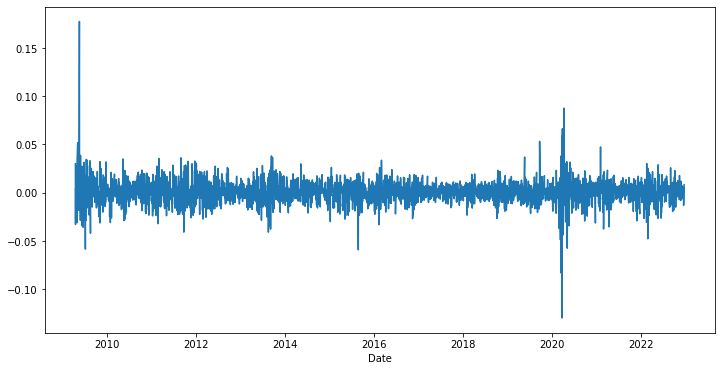

In [211]:
d_returns = plot_daily_returns(d, log=False, squared=False)

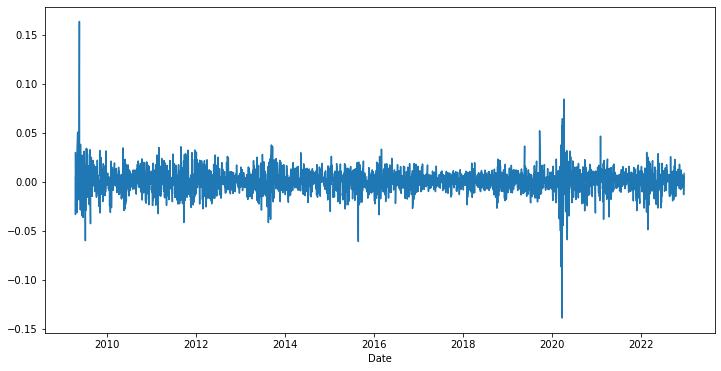

In [212]:
d_log_returns = plot_daily_returns(d, log=True, squared=False)

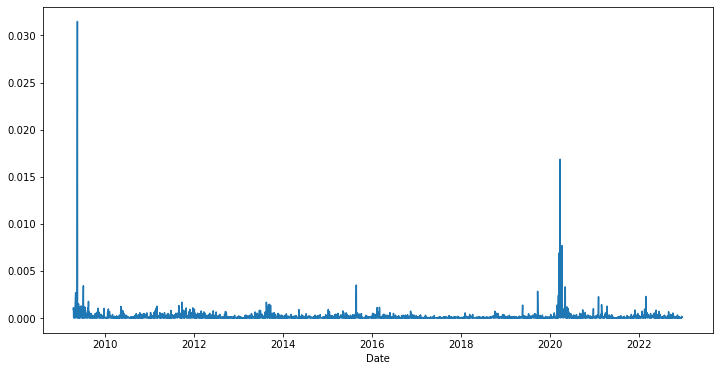

In [213]:
d_squared_returns = plot_daily_returns(d, log=False, squared=True)

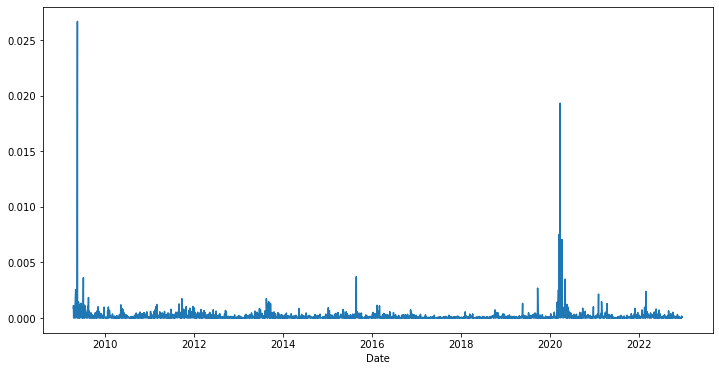

In [214]:
d_squared_log_returns = plot_daily_returns(d, log=True, squared=True)

## Autocorrelation

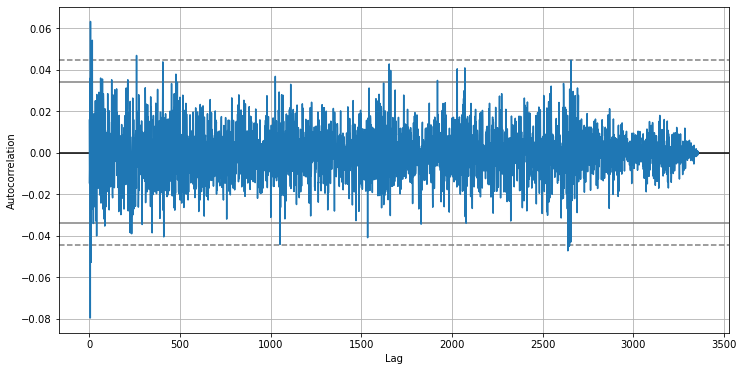

In [215]:
plot_autocor_daily_returns(d_returns)

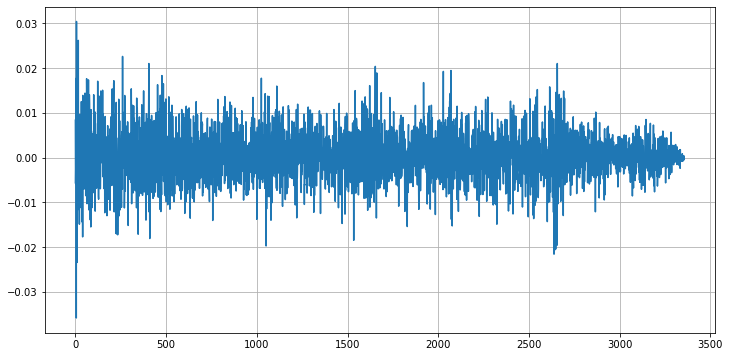

In [216]:
plot_autocor_daily_returns_1(d_returns)

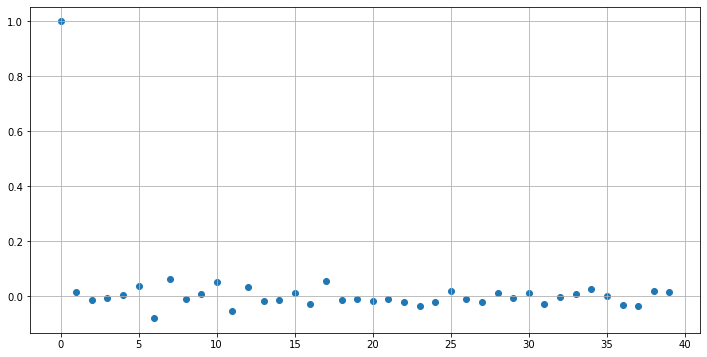

In [217]:
plot_autocor_daily_returns_2(d_returns)

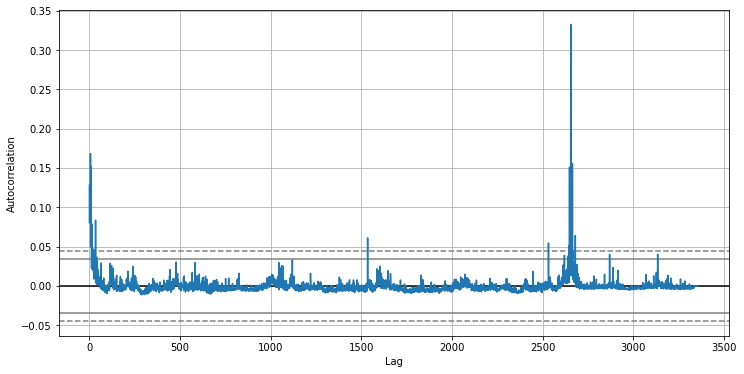

In [218]:
plot_autocor_daily_returns(d_squared_returns)

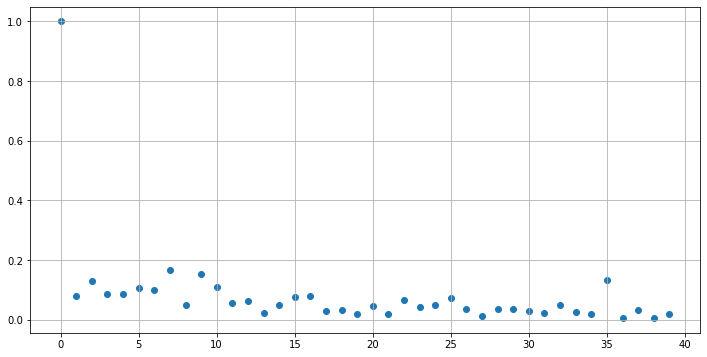

In [219]:
plot_autocor_daily_returns_2(d_squared_returns)

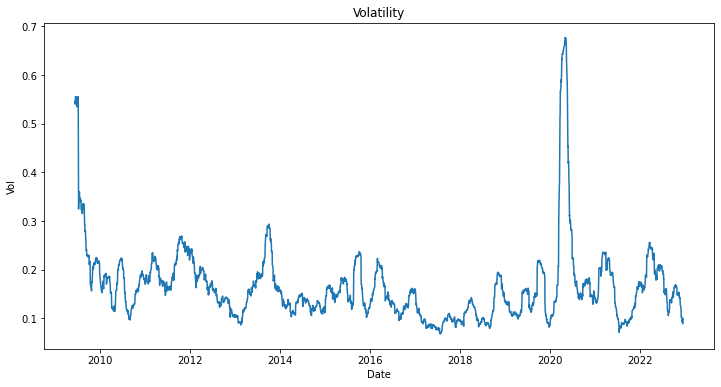

In [220]:
vol_d_returns = plot_volatility_window(d_returns)

## MLE

In [221]:
rd_data = np.random.normal(5, 2.5, 10000)

In [222]:
MLE_normal(rd_data)

(5.040253264222711, 2.493767889306656)

In [223]:
const = [{"type":"ineq", "fun": lambda x: x[1]}] # Sigma > 0
MLE_opt(rd_data, log_likelihood, [0, 1], const)

/var/folders/9s/mnbf7ynj4250m39tyvxgpknw0000gn/T/ipykernel_97747/2581183296.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(sc.stats.norm.pdf(x, mean, sigma)))


array([5.04025849, 2.49376968])

In [224]:
const = [{"type":"ineq", "fun": lambda x: x[0]}, # Kappa > 0
         {"type":"ineq", "fun": lambda x: x[2]}] # Sigma > 0

In [235]:
params_OU = MLE_opt(vol_d_returns, log_likelihood_OU, [1, 3, 1], const)

/var/folders/9s/mnbf7ynj4250m39tyvxgpknw0000gn/T/ipykernel_97747/912123520.py:80: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(sc.stats.norm.pdf(x, mean, sigma)))


In [236]:
print(params_OU)
print(vol_d_returns[-1])

[1.99275233 0.14772178 0.12029951]
0.09883926129361582


In [241]:
vol_OU = simulation_OU(vol_d_returns[-1], params_OU[0], params_OU[1], params_OU[2], 0.3, 10000)


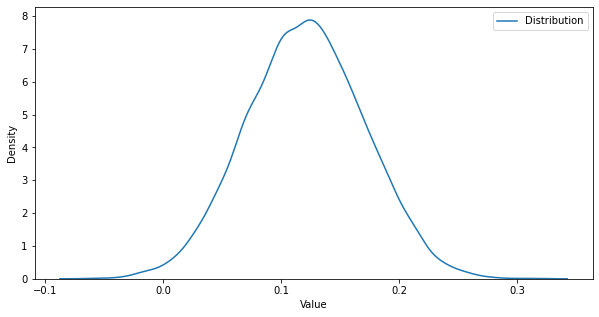

In [242]:
plot_value_distrib(vol_OU)

In [256]:
vol_OU_EM = discretization_EM(vol_d_returns[-1], params_OU[0], params_OU[1], params_OU[2], 2, 10000)


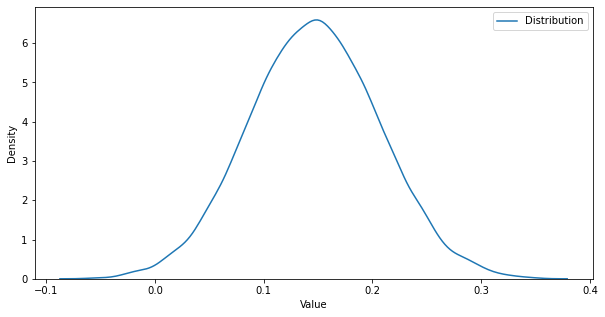

In [257]:
plot_value_distrib(vol_OU_EM[-1])